**Importing Relevant Libraries and Setting up Notebook**

In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import os 
import random as rn

In [2]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [4]:
df = pd.read_csv('GOOG.csv', parse_dates = ['Date'] )

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-01,58.130501,58.700001,57.875999,58.384998,58.384998,48242000
1,2018-02-02,56.099998,56.153500,55.363899,55.595001,55.595001,97158000
2,2018-02-05,54.529999,55.500000,52.601501,52.790001,52.790001,75966000
3,2018-02-06,51.359001,54.085499,51.156849,54.029999,54.029999,68960000
4,2018-02-07,54.077000,54.089001,52.412998,52.429001,52.429001,47384000


In [6]:
df_plot = df.copy()
df.drop('Adj Close', axis = 1, inplace = True)

In [7]:
df_2 = df.copy()

Exploratory Data Analysis

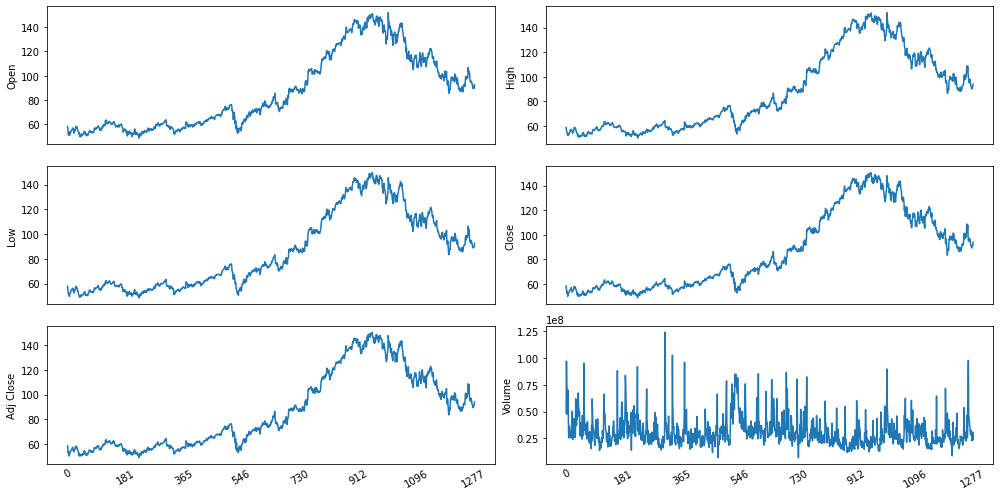

In [8]:
#df_plot = df.copy()
df_plot = df_plot.drop('Date', axis = 1)

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Splitting Data into training and test set. Training Set contains 5 Years of data from February 2018 to January 2023. Test set contains 19 business days from February 2023. In the end we would try to predict stock opening value of first business day of March

In [9]:
train_data = df.loc[df['Date'] <= '2023-1-31']
test_data = df.loc[(df['Date'] > '2023-1-31') & (df['Date'] < '2023-3-1')]

In [10]:
print(train_data.shape)
print(test_data.shape)

(1258, 6)
(19, 6)


# DATA PREPROCESSING

Covnert our training data to array 

In [11]:
train_data_array = train_data.iloc[:,1:6].values

Build separate MinMaxScaler objects for the whole data and the open price. Which will be used later 

In [12]:
sc = MinMaxScaler(feature_range = (0,1))
train_data_scaled = sc.fit_transform(train_data_array)
scaler_pred = MinMaxScaler(feature_range = (0,1))
train_open_scaled = scaler_pred.fit_transform(train_data_array[:,1:2])

Creating a datastructure with 60 timesteps and 1 output 

In [13]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(train_data_scaled[i-60:i, :])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
df_new = df.copy()
df_new = df_new.loc[df_new['Date'] < '2023-3-1']
inputs = df_new.iloc[len(df_new) - len(test_data) - 60:,1:6].values

In [15]:
inputs = sc.transform(inputs)

In [16]:
X_test = []
y_test = []
for i in range(60, 79):
    X_test.append(inputs[i-60:i, :])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1198, 60, 5)
(1198,)
(19, 60, 5)
(19,)


In [18]:
y_train

array([0.02719338, 0.01926944, 0.0262677 , ..., 0.48808508, 0.48512875,
       0.47655053])

# Building a Deep Neural Network 

Four LSTM Layers with 50 neurons in each layer were used and used a regularisation droupout of 20% to avoid the problem of overfitting

In [19]:
regressor = tf.keras.models.Sequential()

In [20]:
##The input_shape only contains the timesteps and the dimensions
regressor.add(tf.keras.layers.LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 
                                                                                       X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.15))

In [21]:
regressor.add(tf.keras.layers.LSTM(units = 70, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.15))

In [22]:
regressor.add(tf.keras.layers.LSTM(units = 70, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.15))

In [23]:
#regressor.add(tf.keras.layers.LSTM(units = 70, return_sequences = True))
#regressor.add(tf.keras.layers.Dropout(0.15))

In [24]:
regressor.add(tf.keras.layers.LSTM(units = 70))
regressor.add(tf.keras.layers.Dropout(0.15))

Final Output Layer

In [25]:
regressor.add(tf.keras.layers.Dense(units = 1))

Compiling and fitting our model

In [26]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
#history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 100
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = regressor.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, y_test)
                   )

Epoch 1/100
38/38 [==============================] - 22s 199ms/step - loss: 0.0229 - val_loss: 0.0043
Epoch 2/100
38/38 [==============================] - 5s 144ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 3/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 4/100
38/38 [==============================] - 6s 146ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 5/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/100
38/38 [==============================] - 5s 141ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 7/100
38/38 [==============================] - 6s 160ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 8/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/100
38/38 [==============================] - 5s 138ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 10/100
38/38 [==============================] - 7s 173ms/step - loss: 0.0038 - val_l

## Plotting the loss function

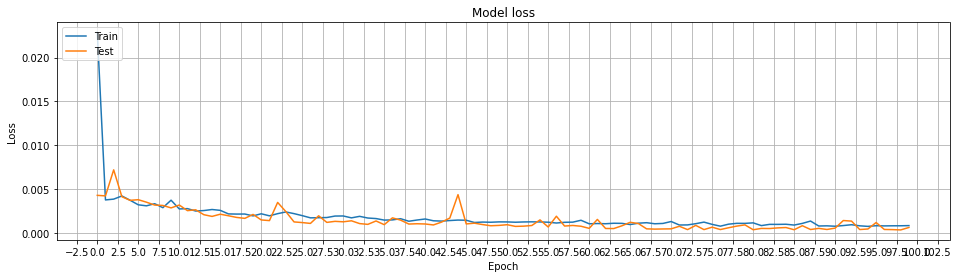

In [29]:
fig, ax = plt.subplots(figsize=(16, 4), sharex=True)
sns.lineplot(data=history.history["loss"])
sns.lineplot(data=history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(45))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Making predictions and visualising 

In [30]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [31]:
predicted_stock_price

array([[0.4630806 ],
       [0.47008342],
       [0.51600474],
       [0.5262563 ],
       [0.5085332 ],
       [0.5123126 ],
       [0.48612997],
       [0.44571078],
       [0.43181276],
       [0.4330369 ],
       [0.4334892 ],
       [0.44191453],
       [0.4452766 ],
       [0.43579558],
       [0.41606116],
       [0.40043116],
       [0.39269245],
       [0.383928  ],
       [0.3827893 ]], dtype=float32)

In [32]:
predicted_stock_prices = scaler_pred.inverse_transform(predicted_stock_price)

In [33]:
predicted_stock_prices.shape

(19, 1)

In [34]:
real_stock_price = test_data.iloc[:,1:2].values

In [35]:
#real_stock_price

In [36]:
#y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
MAE = mean_absolute_error(real_stock_price, predicted_stock_prices)
print(MAE)

1.2110157492804294


In [37]:
MAPE = np.mean((np.abs(np.subtract(real_stock_price, predicted_stock_prices)/ real_stock_price))) * 100

In [38]:
print(MAPE)

1.2060132626063904


Predicting Next day's stock price

In [39]:
##get complete values for past 60 days before end of feb
df_feb = df.loc[(df['Date'] <= '2023-02-28') ]

In [40]:
df_feb.drop('Date', axis = 1, inplace = True)


/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [41]:
df_feb = df_feb[-60:].values

In [42]:
df_feb_scaled = sc.transform(df_feb)

In [43]:
X_test_new = []
X_test_new.append(df_feb_scaled)
X_test_new = np.array(X_test_new)

In [44]:
X_test_new.shape

(1, 60, 5)

In [45]:
pred_price_scaled = regressor.predict(X_test_new)
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled)

1/1 [==============================] - 0s 35ms/step


In [46]:
print(pred_price_unscaled)
df.tail()

[[89.38348]]


,Date,Open,High,Low,Close,Volume
1275,2023-02-27,90.089996,90.449997,89.610001,90.099998,22724300
1276,2023-02-28,89.540001,91.449997,89.519997,90.300003,30546900
1277,2023-03-01,90.160004,91.199997,89.849998,90.510002,26323900
1278,2023-03-02,89.860001,92.480003,89.769997,92.309998,23328600
1279,2023-03-03,92.739998,94.110001,92.660004,94.019997,30220900


# Visualising 

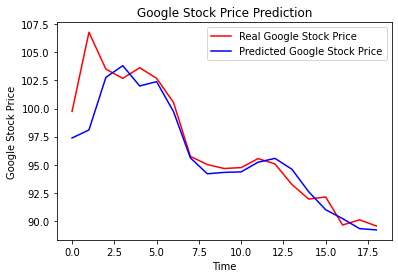

In [47]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [48]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 
df_2.set_index(df_2.columns[0])
#train_data_len = length()
# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_2['Open'][:1198 + 1]).rename(columns={'Open': 'y_train'})
valid = pd.DataFrame(df_2['Open'][1198:1217]).rename(columns={'Open': 'y_test'})
valid.insert(1, "y_pred", predicted_stock_prices, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

In [49]:
df_union

,y_train,y_test,residuals,y_pred
0,58.130501,NaN,NaN,NaN
1,56.099998,NaN,NaN,NaN
2,54.529999,NaN,NaN,NaN
3,51.359001,NaN,NaN,NaN
4,54.077000,NaN,NaN,NaN
...,...,...,...,...
1212,NaN,97.339996,-4.756790,92.583206
1213,NaN,98.464996,-7.474853,90.990143
1214,NaN,97.199997,-6.998604,90.201393
1215,NaN,96.000000,-6.691902,89.308098


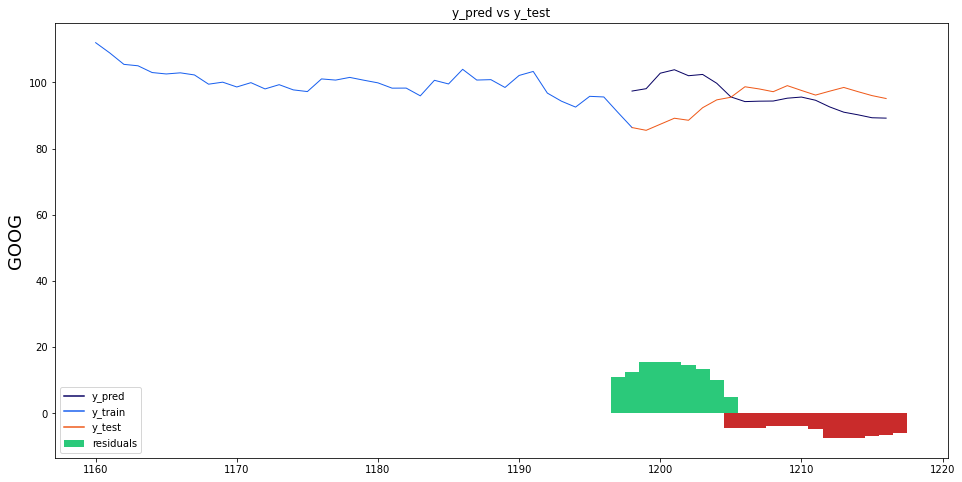

In [50]:

# Zoom in to a closer timeframe
#df_union_zoom = df_union[df_union.index > display_start_date]
df_union_zoom = df_union.iloc[1160:]
#df_union_zoom = df_union.copy()
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('GOOG', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()